In [1]:
import sys,os
import pickle
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc
from IPython.display import Image
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=True'
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
import cell2location
import skimage.io

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


In [2]:
data_dir = '/lustre/scratch117/cellgen/team283/Kidney-Nanostring/'
hires = skimage.io.imread(f'{data_dir}high_res_scans/disease3_scan_CD45.tiff', True)
img = skimage.io.imread(f'{data_dir}ROI reports/disease3_scan.png', True)
# what is the resize factor?
np.array(img.shape) / np.array(hires.shape)

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/PIL/Image.py:2850: DecompressionBombWarning: Image size (161360549 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.


array([0.21986084, 0.18227132])

In [3]:
data_dir = '/lustre/scratch117/cellgen/team283/Kidney-Nanostring/'
adata_wta = sc.read_h5ad(f'{data_dir}resultsLocationModelWTA_1experiments_33clusters_231locations_9551genes/sp.h5ad')

# add coordinates
adata_wta.obsm['spatial'] = adata_wta.obs[['ROICoordinateX', 'ROICoordinateY']].values

# read images
adata_wta.uns['spatial'] = {}
for s in adata_wta.obs['SlideName'].unique():
    img = skimage.io.imread(f'{data_dir}ROI reports/{s}_scan.png', True)
    
    adata_wta.uns['spatial'][s] = {
        'images': {'hires': img},
        'metadata': {'chemistry_description': "Nanostring WTA",
                     'software_version': 'NA'},
        'scalefactors': {'fiducial_diameter_fullres': 500,
                         'spot_diameter_fullres': 500,
                         'tissue_hires_scalef': np.mean(np.array(img.shape) / np.array(hires.shape)),
                         'tissue_lowres_scalef': 1}
    }

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/PIL/Image.py:2850: DecompressionBombWarning: Image size (90187776 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/PIL/Image.py:2850: DecompressionBombWarning: Image size (121868084 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/PIL/Image.py:2850: DecompressionBombWarning: Image size (91075336 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/PIL/Image.py:2850: DecompressionBombWarning: Image size (94257537 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-p

In [4]:
adata_wta.obsm['spatial'][:, 1] = -adata_wta.obsm['spatial'][:, 1]

In [7]:
# defining useful function
def select_slide(adata, s, s_col='SlideName'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [8]:
adata_wta.obs['SlideName'].value_counts()

disease3     59
normal3      55
disease1B    24
disease2B    24
disease4     24
normal4      23
normal2B     22
Name: SlideName, dtype: int64

In [9]:
adata_wta

AnnData object with n_obs × n_vars = 231 × 18503
    obs: 'SlideName', 'ScanName', 'ROILabel', 'SegmentLabel', 'SegmentDisplayName', 'Sample_ID', 'AOISurfaceArea', 'AOINucleiCount', 'ROICoordinateX', 'ROICoordinateY', 'RawReads', 'TrimmedReads', 'StitchedReads', 'AlignedReads', 'DeduplicatedReads', 'SequencingSaturation', 'UMIQ30', 'RTSQ30', 'disease_status', 'pathology', 'region', 'LOQ', 'NormalizationFactor', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'sample', 'mean_spot_factorsAscending vasa recta endothelium', 'mean_spot_factorsB cell', 'mean_spot_factorsCD4 T cell', 'mean_spot_factorsCD8 T cell', 'mean_spot_factorsConnecting tubule', 'mean_spot_factorsDescending vasa recta endothelium', 'mean_spot_factorsDistinct proximal tubule 1', 'mean_spot_factorsDistinct proximal tubule 2', 'mean_spot_factorsEpithelial progenitor cell', 'mean_spot_factorsFibroblast', 'mean_spot_factorsGlomerular endothelium', 'mean_spot_factorsIndistinct intercalated cell', 'm

In [5]:
adata_wta.obs['AOISurfaceArea']

,SlideName,ScanName,ROILabel,SegmentLabel,SegmentDisplayName,Sample_ID,AOISurfaceArea,AOINucleiCount,ROICoordinateX,ROICoordinateY,...,q95_nUMI_factorsPeritubular capillary endothelium 2,q95_nUMI_factorsPlasmacytoid dendritic cell,q95_nUMI_factorsPodocyte,q95_nUMI_factorsPrincipal cell,q95_nUMI_factorsProliferating Proximal Tubule,q95_nUMI_factorsProximal tubule,q95_nUMI_factorsThick ascending limb of Loop of Henle,q95_nUMI_factorsTransitional urothelium,q95_nUMI_factorsType A intercalated cell,q95_nUMI_factorsType B intercalated cell
0,disease3,disease3_scan,1,PanCK,disease3_scan | 001 | PanCK,DSP-1001250007864-D-H01,22152.10924,183,23572,-39228,...,947.508914,1018.383493,1347.475946,14416.419873,1286.178992,10566.347852,4526.405933,389.557944,19706.120410,2616.744397
1,disease3,disease3_scan,1,neg,disease3_scan | 001 | neg,DSP-1001250007864-D-H02,71817.92407,421,23572,-39228,...,1863.116180,766.550085,3049.071814,1976.455194,3173.936694,41937.011914,559.355319,756.040775,6300.814966,1648.453436
2,disease3,disease3_scan,2,PanCK,disease3_scan | 002 | PanCK,DSP-1001250007864-D-H03,37316.69780,323,22404,-47078,...,1448.042383,772.351224,398.381650,39028.996680,1841.522400,10708.542383,11771.256543,1286.966864,5919.671924,9073.736914
3,disease3,disease3_scan,2,neg,disease3_scan | 002 | neg,DSP-1001250007864-D-H04,102112.72680,565,22404,-47078,...,2297.282910,1226.259448,2148.538306,2429.753003,3156.659497,28886.371289,12986.551172,709.694266,11875.331641,4559.702173
4,disease3,disease3_scan,3,PanCK,disease3_scan | 003 | PanCK,DSP-1001250007864-D-H05,18398.68515,162,26308,-51612,...,177.507760,416.478090,960.285080,4497.451733,1115.779840,7286.876953,4036.539014,389.258864,10888.863135,3839.277014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,disease1B,disease1B_scan,20,Geometric Segment,disease1B_scan | 020 | Geometric Segment,DSP-1001250007868-B-A07,34871.37949,185,28871,-20331,...,55.393276,107.395295,212.471370,108.303801,61.628042,116.351788,294.930289,156.059005,59.862989,372.184383
227,disease1B,disease1B_scan,21,Geometric Segment,disease1B_scan | 021 | Geometric Segment,DSP-1001250007868-B-A08,29638.49826,167,28494,-20693,...,111.270570,43.627257,114.333653,62.185731,51.077716,95.757621,221.562689,448.826035,80.526471,558.458972
228,disease1B,disease1B_scan,22,Geometric Segment,disease1B_scan | 022 | Geometric Segment,DSP-1001250007868-B-A09,24203.53455,145,32218,-31068,...,75.720391,22.590508,49.291967,84.903893,58.518222,336.378986,193.014465,207.920760,73.598048,159.639888
229,disease1B,disease1B_scan,23,Geometric Segment,disease1B_scan | 023 | Geometric Segment,DSP-1001250007868-B-A10,24850.07060,162,32556,-30116,...,75.505900,30.205906,74.704984,50.111333,46.448823,209.726792,624.556827,249.006367,66.742857,452.594864


Trying to set attribute `.uns` of view, copying.


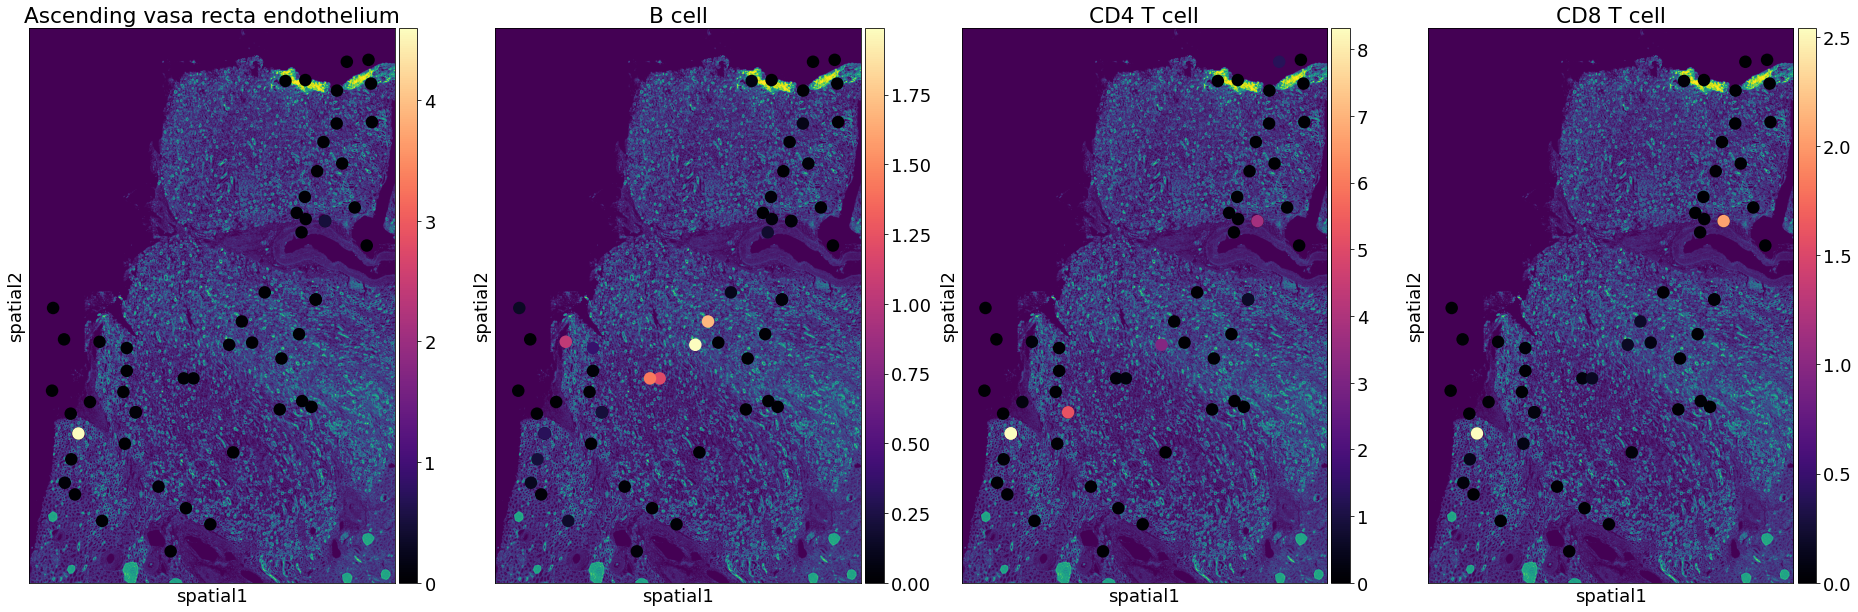

In [10]:
sel_clust = adata_wta.uns['mod']['fact_names']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

# select one section correctly subsetting histology image data
slide = select_slide(adata_wta, 'normal3', s_col='SlideName')
#slide = adata_wta[adata_wta.obs['SlideName'] == 'normal3',:].copy()

# plot with nice names
with mpl.rc_context({'figure.figsize': (7, 10), "font.size": 18}):
    # add slide.obs with nice names
    slide.obs[sel_clust] = slide.obs[sel_clust_col]

    sc.pl.spatial(slide, cmap='magma',
                  color=sel_clust[0:4], # limit size in this notebook
                  ncols=5,
                  spot_size=1000, img_key='hires',
                  #alpha_img=0.9,
                  vmin=0, vmax='p99.2'
                 )

In [ ]:
sel_clust = adata_wta.uns['mod']['fact_names']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

# select one section correctly subsetting histology image data
#slide = select_slide(adata_vis, 'ST8059048')
slide = adata_wta[adata_wta.obs['SlideName'] == 'disease3',:].copy()

# plot with nice names
with mpl.rc_context({'figure.figsize': (7, 10), "font.size": 18}):
    # add slide.obs with nice names
    slide.obs[sel_clust] = slide.obs[sel_clust_col]

    sc.pl.spatial(slide, cmap='magma',
                  color=sel_clust, # limit size in this notebook
                  ncols=5,
                  spot_size=1000, img_key='hires',
                  #alpha_img=0.9,
                  vmin=0, vmax='p99.2'
                 )

In [ ]:
reg_path = "/nfs/team283/aa16/data/Kidney-Nanostring/scrna/regression_model/RegressionGeneBackgroundCoverageTorch_46covariates_40268cells_10882genes/"
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')

In [4]:
# Column name containing cell type annotations
covariate_col_names = 'celltype'

# Extract a pd.DataFrame with signatures from anndata object
inf_aver = adata_snrna_raw.raw.var.copy()
inf_aver = inf_aver.loc[:, [f'means_cov_effect_{covariate_col_names}_{i}' for i in adata_snrna_raw.obs[covariate_col_names].unique()]]
from re import sub
inf_aver.columns = [sub(f'means_cov_effect_{covariate_col_names}_{i}', '', i) for i in adata_snrna_raw.obs[covariate_col_names].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# normalise by average experiment scaling factor (corrects for sequencing depth)
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

In [ ]:
counts_negativeProbes = adata_wta.obsm['negProbes']
counts_nuclei = np.asarray(adata_wta.obs['AOINucleiCount'])

In [ ]:
adata_wta.raw = adata_wta

In [ ]:
inf_aver.index = np.array(adata_snrna_raw.var.loc[inf_aver.index,'SYMBOL'])

In [ ]:
cell2location.run_c2l.run_cell2location(inf_aver, adata_wta, 
        model_name=cell2location.models.LocationModelWTA,
        train_args={'use_raw': True},
        model_kwargs={
        "Y_data" : counts_negativeProbes,
        "cell_number_prior" : {'cells_per_spot': counts_nuclei, 'factors_per_spot': 6, 'combs_per_spot': 3},
        "cell_number_var_prior" : {'cells_mean_var_ratio': 1, 'factors_mean_var_ratio': 1, 'combs_mean_var_ratio': 1}})